In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
movies=pd.read_csv(r"F:\Python34\5000_movies.csv")
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [4]:
ratings=pd.read_csv(r"F:\Python34\ratings_small.csv")
ratings.head(1)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [7]:
print(movies['genres'].isnull().sum())

0


In [12]:
credits=pd.read_csv(r"F:\Python34\5000_credits.csv")
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [13]:
print(credits['crew'].isnull().sum())

0


In [15]:
credits = credits[['movie_id', 'cast', 'crew']]

In [18]:
movies_with_credits = pd.merge(movies, credits, on=movies.id)

print(movies_with_credits.head())

    key_0     budget                                             genres  \
0   19995  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1     285  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  206647  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3   49026  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4   49529  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, 

In [19]:
vectorizer_genres = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
X_genres = vectorizer_genres.fit_transform(movies_with_credits['genres'])

C:\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [20]:
vectorizer_cast = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
X_cast = vectorizer_cast.fit_transform(movies_with_credits['cast'])

In [21]:
vectorizer_crew = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
X_crew = vectorizer_crew.fit_transform(movies_with_credits['crew'])


In [22]:
from scipy.sparse import hstack

X_combined = hstack([X_genres, X_cast, X_crew])

In [23]:
print("Combined feature shape:", X_combined.shape)

Combined feature shape: (4803, 10718)


In [24]:
n_clusters = 10

In [25]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_combined)

KMeans(n_clusters=10, random_state=42)

In [26]:
movies_with_credits['cluster'] = kmeans.labels_

print(movies_with_credits.head())

    key_0     budget                                             genres  \
0   19995  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1     285  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  206647  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3   49026  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4   49529  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, 

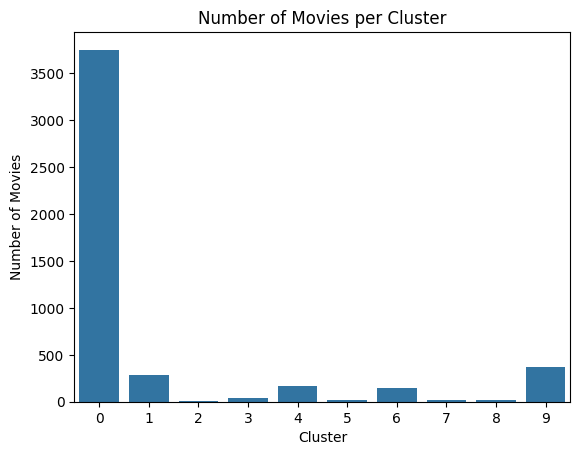

In [27]:
sns.countplot(data=movies_with_credits, x='cluster')
plt.title('Number of Movies per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Movies')
plt.show()

In [37]:
def recommend_movies_with_credits(movie_title, movies_df, ratings_df, top_n=5):
    # Find the cluster of the given movie
    cluster = movies_df[movies_df['title'] == movies.title]['cluster'].values[0]
    
    # Find other movies in the same cluster
    cluster_movies = movies_df[movies_df['cluster'] == cluster]
    
    # Merge with ratings to get average ratings
    cluster_ratings = pd.merge(cluster_movies, ratings_df[['movieId', 'rating']], on=movies.id)
    avg_ratings = cluster_ratings.groupby(movies.id).agg({'rating': 'mean'}).reset_index()
    
    # Merge with movie data to get movie titles and genres
    cluster_movies_with_ratings = pd.merge(cluster_movies, avg_ratings, on=movies.id)
    
    # Exclude the input movie from the recommendations
    recommendations = cluster_movies_with_ratings[cluster_movies_with_ratings['title'] != movies.title]
    
    # Sort by average rating
    recommendations = recommendations.sort_values(by='rating', ascending=False)
    
    return recommendations[['title', 'genres', 'rating']].head()



In [38]:
print(recommend_movies_with_credits('Avatar', movies_with_credits, ratings))

KeyError: array([ 19995,    285, 206647, ..., 231617, 126186,  25975], dtype=int64)

In [40]:
def recommend_movies_with_credits(movie_title, movies_df, ratings_df, top_n=5):
    """
    Recommend movies similar to a given movie based on clustering and ratings.

    Parameters:
    - movie_title: Title of the movie for which recommendations are to be made.
    - movies_df: DataFrame containing movie data with clusters.
    - ratings_df: DataFrame containing user ratings.
    - top_n: Number of top recommendations to return.

    Returns:
    - A DataFrame with top_n recommended movies including title, genres, and average rating.
    """
    # Ensure the movie exists in the dataset
    if movie_title not in movies_df['title'].values:
        raise ValueError(f"Movie title '{movie_title}' not found in dataset.")

    # Find the cluster of the given movie
    cluster = movies_df[movies_df['title'] == movie_title]['cluster'].values[0]
    
    # Find other movies in the same cluster
    cluster_movies = movies_df[movies_df['cluster'] == cluster]
    
    # Merge with ratings to get average ratings
    cluster_ratings = pd.merge(cluster_movies, ratings_df[['movieId', 'rating']], on=movies.id)
    avg_ratings = cluster_ratings.groupby(movies.id).agg({'rating': 'mean'}).reset_index()
    
    # Merge with movie data to get movie titles and genres
    cluster_movies_with_ratings = pd.merge(cluster_movies, avg_ratings, on=movies.id)
    
    # Exclude the input movie from the recommendations
    recommendations = cluster_movies_with_ratings[cluster_movies_with_ratings['title'] != movie_title]
    
    # Sort by average rating
    recommendations = recommendations.sort_values(by='rating', ascending=False)
    
    return recommendations[['title', 'genres', 'rating']].head(top_n)

# Example refined recommendation
recommended_movies = recommend_movies_with_credits('The Matrix', movies_with_credits, ratings)
print(recommended_movies)


KeyError: array([ 19995,    285, 206647, ..., 231617, 126186,  25975], dtype=int64)

In [41]:
print("Movies DataFrame columns:", movies_with_credits.columns)

Movies DataFrame columns: Index(['key_0', 'budget', 'genres', 'homepage', 'id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'movie_id', 'cast', 'crew', 'cluster'],
      dtype='object')


In [42]:
print("Ratings DataFrame columns:", ratings.columns)

Ratings DataFrame columns: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [56]:
print(movies_with_credits[['title', 'id']].head())

                                      title      id
0                                    Avatar   19995
1  Pirates of the Caribbean: At World's End     285
2                                   Spectre  206647
3                     The Dark Knight Rises   49026
4                               John Carter   49529


In [57]:
print(ratings[['movieId', 'rating']].head())

   movieId  rating
0       31     2.5
1     1029     3.0
2     1061     3.0
3     1129     2.0
4     1172     4.0


In [58]:
ratings.shape

(100004, 4)

In [60]:
def recommend_movies_with_credits(movie_title, movies_df, ratings_df, top_n=5):
    """
    Recommend movies similar to a given movie based on clustering and ratings.

    Parameters:
    - movie_title: Title of the movie for which recommendations are to be made.
    - movies_df: DataFrame containing movie data with clusters.
    - ratings_df: DataFrame containing user ratings.
    - top_n: Number of top recommendations to return.

    Returns:
    - A DataFrame with top_n recommended movies including title, genres, and average rating.
    """
    # Check that required columns exist
    required_columns_movies = {'title', 'id', 'cluster'}
    required_columns_ratings = {'movieId', 'rating'}
    
    if not required_columns_movies.issubset(movies_df.columns):
        raise KeyError(f"Movies DataFrame is missing columns: {required_columns_movies - set(movies_df.columns)}")
    if not required_columns_ratings.issubset(ratings_df.columns):
        raise KeyError(f"Ratings DataFrame is missing columns: {required_columns_ratings - set(ratings_df.columns)}")

    # Ensure the movie exists in the dataset
    if movie_title not in movies_df['title'].values:
        raise ValueError(f"Movie title '{movie_title}' not found in dataset.")

    # Find the cluster of the given movie
    cluster = movies_df[movies_df['title'] == movie_title]['cluster'].values[0]
    
    # Find other movies in the same cluster
    cluster_movies = movies_df[movies_df['cluster'] == cluster]
    
    # Merge with ratings to get average ratings
    cluster_ratings = pd.merge(cluster_movies, ratings_df[['movieId', 'rating']], on=ratings.movieId)
    avg_ratings = cluster_ratings.groupby(ratings.movieId).agg({'rating': 'mean'}).reset_index()
    
    # Merge with movie data to get movie titles and genres
    cluster_movies_with_ratings = pd.merge(cluster_movies, avg_ratings, on=ratings.movieId)
    
    # Exclude the input movie from the recommendations
    recommendations = cluster_movies_with_ratings[cluster_movies_with_ratings['title'] != movie_title]
    
    # Sort by average rating
    recommendations = recommendations.sort_values(by='rating', ascending=False)
    
    return recommendations[['title', 'genres', 'rating']].head(top_n)

# Example refined recommendation
try:
    recommended_movies = recommend_movies_with_credits('The Matrix', movies_with_credits, ratings)
    print(recommended_movies)
except KeyError as e:
    print(f"KeyError: {e}")
except ValueError as e:
    print(f"ValueError: {e}")


KeyError: array([  31, 1029, 1061, ..., 6365, 6385, 6565], dtype=int64)
